In [7]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [3]:
import os

# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3')

# Print the current working directory to confirm the change
print(f"Current working directory: {os.getcwd()}")


Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3


# Load data

In [4]:
def load_gtex_data(file_path):
    """
    Load GTEx .gct.gz file into a pandas DataFrame
    
    Parameters:
    file_path (str): Path to the GTEx gct.gz file
    
    Returns:
    tuple: (data_df, description_df, metadata_dict)
    """
    # Read the first few lines to get metadata
    with gzip.open(file_path, 'rt') as f:
        version = f.readline().strip()  # First line: version
        dims = f.readline().strip().split('\t')  # Second line: dimensions
        
    # Parse dimensions
    n_genes, n_samples = map(int, dims)
    
    # Read the actual data, skipping the first two metadata lines
    # GCT format has gene names in first column, descriptions in second column
    data_df = pd.read_csv(file_path, 
                         compression='gzip',
                         sep='\t', 
                         skiprows=2)
    
    # Separate gene descriptions from expression data
    description_df = data_df.iloc[:, :2]
    expression_df = data_df.iloc[:, 2:]
    
    # Set gene names as index
    expression_df.index = data_df.iloc[:, 0]
    
    # Create metadata dictionary
    metadata = {
        'version': version,
        'n_genes': n_genes,
        'n_samples': n_samples
    }
    
    return expression_df, description_df, metadata

def basic_analysis(expression_df):
    """
    Perform basic analysis on the expression data
    
    Parameters:
    expression_df (pd.DataFrame): Expression data matrix
    
    Returns:
    dict: Dictionary containing analysis results
    """
    analysis = {
        'total_transcripts': len(expression_df),
        'total_samples': len(expression_df.columns),
        'mean_expression': expression_df.mean().mean(),
        'median_expression': expression_df.median().median(),
        'non_zero_fraction': (expression_df > 0).mean().mean() * 100,
        'genes_detected_per_sample': (expression_df > 0).sum(),
        'sample_stats': expression_df.describe()
    }
    return analysis

def filter_low_expression(expression_df, min_tpm=1, min_samples=10):
    """
    Filter out lowly expressed transcripts
    
    Parameters:
    expression_df (pd.DataFrame): Expression data matrix
    min_tpm (float): Minimum TPM threshold
    min_samples (int): Minimum number of samples that must exceed min_tpm
    
    Returns:
    pd.DataFrame: Filtered expression matrix
    """
    # Count samples exceeding threshold for each transcript
    samples_above_threshold = (expression_df >= min_tpm).sum(axis=1)
    
    # Filter transcripts
    filtered_df = expression_df[samples_above_threshold >= min_samples]
    
    return filtered_df

def plot_expression_distribution(expression_df, output_file=None):
    """
    Plot distribution of expression values
    
    Parameters:
    expression_df (pd.DataFrame): Expression data matrix
    output_file (str): Optional path to save the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Calculate mean expression per transcript
    mean_expression = expression_df.mean(axis=1)
    
    # Plot distribution of log2 transformed mean expression
    sns.histplot(np.log2(mean_expression + 1), bins=50)
    plt.xlabel('Log2(TPM + 1)')
    plt.ylabel('Count')
    plt.title('Distribution of Mean Expression Values')
    
    if output_file:
        plt.savefig(output_file)
    plt.close()

In [5]:
file_path = "GTEx_Analysis_2017-06-05_v8_RSEMv1.3.0_transcript_tpm.gct.gz"

# Load data
expression_df, description_df, metadata = load_gtex_data(file_path)

In [8]:
pickle_file = "gtex_data.pkl"

with open(pickle_file, 'wb') as f:
    pickle.dump((expression_df, description_df, metadata), f)
print("Data loaded from original file and saved to pickle file.")

Data loaded from original file and saved to pickle file.


In [ ]:
if os.path.exists(pickle_file):
    # Load data from pickle file if it exists
    with open(pickle_file, 'rb') as f:
        expression_df, description_df, metadata = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    print("Pickle file does not exist. Please run the script to create it.")

In [6]:
# Print basic information
print(f"Dataset version: {metadata['version']}")
print(f"Number of transcripts: {metadata['n_genes']}")
print(f"Number of samples: {metadata['n_samples']}")

Dataset version: #1.2
Number of transcripts: 199324
Number of samples: 17382


In [11]:
print(type(expression_df))
expression_df.head()


<class 'pandas.core.frame.DataFrame'>


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,...,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000373020.8,26.32,3.95,13.23,30.15,6.60,38.70,29.30,19.25,45.25,8.79,...,5.73,16.51,17.06,8.28,3.96,68.85,30.73,5.05,1.67,32.91
ENST00000494424.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENST00000496771.5,2.53,0.48,1.98,4.18,0.38,2.96,11.20,1.25,1.41,0.33,...,0.80,0.88,0.96,1.03,0.73,28.48,0.89,0.56,0.50,2.14
ENST00000612152.4,0.47,0.21,0.15,1.23,0.31,1.26,1.41,0.56,1.42,0.37,...,0.23,0.33,0.59,0.45,0.24,5.59,0.20,0.20,0.14,0.99
ENST00000614008.4,0.23,0.24,1.32,1.15,0.74,0.00,5.49,0.00,0.00,0.16,...,0.30,0.00,0.00,0.18,0.45,4.23,0.00,0.42,0.00,0.39


In [12]:
print(type(description_df))
description_df.head()


<class 'pandas.core.frame.DataFrame'>


,transcript_id,gene_id
0,ENST00000373020.8,ENSG00000000003.14
1,ENST00000494424.1,ENSG00000000003.14
2,ENST00000496771.5,ENSG00000000003.14
3,ENST00000612152.4,ENSG00000000003.14
4,ENST00000614008.4,ENSG00000000003.14


In [14]:
type(metadata)
metadata

{'version': '#1.2', 'n_genes': 199324, 'n_samples': 17382}

In [16]:
%%script false --no-raise-error
# Perform basic analysis
analysis_results = basic_analysis(expression_df)
print("\nBasic Analysis Results:")
for key, value in analysis_results.items():
    if not isinstance(value, pd.DataFrame):
        print(f"{key}: {value}")

In [17]:
%%script false --no-raise-error
# Filter low expression
filtered_df = filter_low_expression(expression_df, min_tpm=1, min_samples=10)
print(f"\nTranscripts after filtering: {len(filtered_df)}")

# Plot expression distribution
plot_expression_distribution(filtered_df, "expression_distribution.png")

# SRRM3


In [20]:
canonical_refseq = "NM_001110199.3"
noncanonical_refseq = "NM_001291831.2"

In [26]:
# %% Find SRRM3 transcripts using ENSEMBL gene ID (https://grch37.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000177679;r=7:75831216-75916605)
srrm3_entries = description_df[description_df['gene_id'].str.contains('ENSG00000177679', na=False)]
print("SRRM3 transcripts found:")
print(srrm3_entries)

SRRM3 transcripts found:
            transcript_id             gene_id
117190  ENST00000464752.1  ENSG00000177679.15
117191  ENST00000479284.1  ENSG00000177679.15
117192  ENST00000479294.2  ENSG00000177679.15
117193  ENST00000611745.1  ENSG00000177679.15
117194  ENST00000612155.1  ENSG00000177679.15



Expression data shape: (5, 17382)

Transcript statistics:
                        mean  median        std  non_zero_samples
transcript_id                                                    
ENST00000464752.1   1.043077   0.000   5.050371              7821
ENST00000479284.1   4.993698   0.000  23.739719              6405
ENST00000479294.2   0.041775   0.000   0.244361              1949
ENST00000611745.1   2.498653   0.060  10.802768             12715
ENST00000612155.1  10.311903   3.485  25.462715             17167

Found MANE Select transcript: ENST00000611745.1
Mean expression: 2.50 TPM


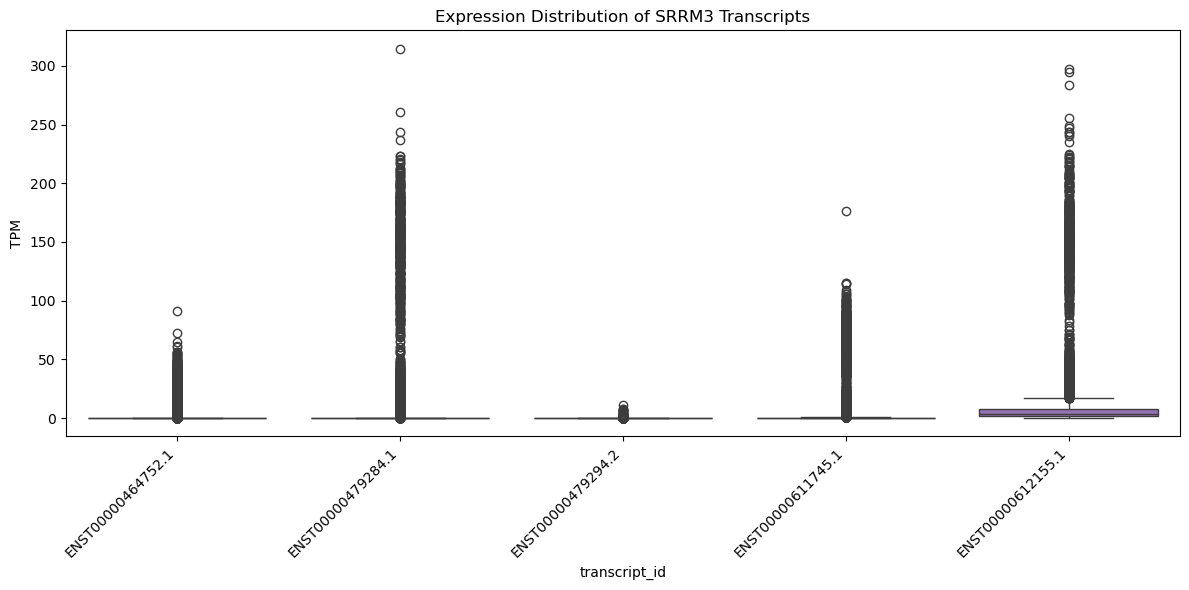

In [28]:
# %% Get expression data for these transcripts
srrm3_transcripts = expression_df.loc[srrm3_entries['transcript_id']]
print("\nExpression data shape:", srrm3_transcripts.shape)

# %% Get basic statistics for each transcript
stats = pd.DataFrame({
    'mean': srrm3_transcripts.mean(axis=1),
    'median': srrm3_transcripts.median(axis=1),
    'std': srrm3_transcripts.std(axis=1),
    'non_zero_samples': (srrm3_transcripts > 0).sum(axis=1)
})
print("\nTranscript statistics:")
print(stats)

# %% Look for our transcript of interest (MANE Select)
mane_select = "ENST00000611745"  # This corresponds to NM_001110199.3 (variant without exon 15)
mane_transcripts = [t for t in srrm3_transcripts.index if t.startswith(mane_select)]
if mane_transcripts:
    print(f"\nFound MANE Select transcript: {mane_transcripts[0]}")
    print(f"Mean expression: {srrm3_transcripts.loc[mane_transcripts[0]].mean():.2f} TPM")
else:
    print(f"\nMANE Select transcript {mane_select} not found")

# %% Plot expression distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=srrm3_transcripts.T)
plt.xticks(rotation=45, ha='right')
plt.title('Expression Distribution of SRRM3 Transcripts')
plt.ylabel('TPM')
plt.tight_layout()
plt.show()

# Differnet brain regions

In [145]:
# %% Function to load brain region data
def load_brain_data(file_list):
    """
    Load GTEx brain region-specific data files
    
    Parameters:
    file_list (list): List of file paths for brain region data
    
    Returns:
    dict: Dictionary with region names as keys and DataFrames as values
    """
    brain_data = {}
    
    for file_path in file_list:
        # Extract region name from file path
        region = file_path.split('gene_tpm_2017-06-05_v8_brain_')[1].split('.gct.gz')[0]
        print(f"Loading data for {region}...")
        
        try:
            # Load data
            expr_df, desc_df, meta = load_gtex_data(file_path)
            
            # Store in dictionary
            brain_data[region] = {
                'expression': expr_df,
                'description': desc_df,
                'metadata': meta
            }
        except Exception as e:
            print(f"Error loading {region}: {str(e)}")
            continue
    
    return brain_data

# %% Modified function to load GCT files
def load_gtex_data(file_path):
    """
    Load GTEx .gct.gz file into a pandas DataFrame
    
    Parameters:
    file_path (str): Path to the GTEx gct.gz file
    
    Returns:
    tuple: (data_df, description_df, metadata_dict)
    """
    # Read the first few lines to get metadata
    with gzip.open(file_path, 'rt') as f:
        version = f.readline().strip()  # First line: version
        dims_line = f.readline().strip().split('\t')  # Second line: dimensions
        
    # Parse dimensions - take first two numbers regardless of format
    n_genes = int(dims_line[0])
    n_samples = int(dims_line[1])
    
    # Read the actual data
    data_df = pd.read_csv(file_path, 
                         compression='gzip',
                         sep='\t', 
                         skiprows=2)
    
    # Get the first two columns (Name/Description or gene_id/gene_name)
    first_col = data_df.columns[0]
    second_col = data_df.columns[1]
    
    # Separate gene descriptions from expression data
    description_df = data_df.iloc[:, :2].copy()
    description_df.columns = ['gene_id', 'gene_name']  # Rename columns consistently
    
    # Create expression DataFrame
    expression_df = data_df.iloc[:, 2:]
    expression_df.index = data_df[first_col]  # Use first column as index
    
    metadata = {
        'version': version,
        'n_genes': n_genes,
        'n_samples': n_samples
    }
    
    return expression_df, description_df, metadata

In [146]:
# %% Load brain region data
brain_files = [
    "gene_tpm_2017-06-05_v8_brain_amygdala.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_nucleus_accumbens_basal_ganglia.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_anterior_cingulate_cortex_ba24.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_putamen_basal_ganglia.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_caudate_basal_ganglia.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_spinal_cord_cervical_c-1.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_cerebellar_hemisphere.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_substantia_nigra.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_cerebellum.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_cortex.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_frontal_cortex_ba9.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_hippocampus.gct.gz",
    "gene_tpm_2017-06-05_v8_brain_hypothalamus.gct.gz"
]

brain_data = load_brain_data(brain_files)

Loading data for amygdala...


Loading data for nucleus_accumbens_basal_ganglia...
Loading data for anterior_cingulate_cortex_ba24...
Loading data for putamen_basal_ganglia...
Loading data for caudate_basal_ganglia...
Loading data for spinal_cord_cervical_c-1...
Loading data for cerebellar_hemisphere...
Loading data for substantia_nigra...
Loading data for cerebellum...
Loading data for cortex...
Loading data for frontal_cortex_ba9...
Loading data for hippocampus...
Loading data for hypothalamus...


In [147]:
# %% Save to pickle
brain_pickle = "gtex_brain_data.pkl"
print("Saving brain data to pickle file...")
with open(brain_pickle, 'wb') as f:
    pickle.dump(brain_data, f)
print("Data saved.")

Saving brain data to pickle file...
Data saved.


In [169]:
# %% Load brain data from pickle
brain_pickle = "gtex_brain_data.pkl"
print("Loading brain data from pickle file...")
with open(brain_pickle, 'rb') as f:
    brain_data = pickle.load(f)
print("Data loaded.")

Loading brain data from pickle file...
Data loaded.


In [158]:
# %% Verify the data format
region = list(brain_data.keys())[0]
print(f"\nRegion: {region}")
print("\nDescription data shape:")
print(brain_data[region]['description'].shape)
print("\nExpression data shape:")
print(brain_data[region]['expression'].shape)
print("\n---")


Region: amygdala

Description data shape:
(56200, 2)

Expression data shape:
(56200, 153)

---


In [149]:
# %%script false --no-raise-error
# %% Verify the data format
region = list(brain_data.keys())[0]
print(f"\nRegion: {region}")
print("\nDescription data format:")
print(brain_data[region]['description'].head())
print("\nExpression data format:")
print(brain_data[region]['expression'].head())
print("\n---")



Region: amygdala

Description data format:
   gene_id          gene_name
0        0  ENSG00000223972.5
1        1  ENSG00000227232.5
2        2  ENSG00000278267.1
3        3  ENSG00000243485.5
4        4  ENSG00000237613.2

Expression data format:
    Description  GTEX-11NUK-0011-R4a-SM-DO12B  GTEX-11ONC-0011-R4b-SM-DO93H  \
id                                                                            
0       DDX11L1                        0.0718                        0.0000   
1        WASH7P                        0.7852                        0.9886   
2     MIR6859-1                        0.0000                        0.0000   
3   MIR1302-2HG                        0.1147                        0.0000   
4       FAM138A                        0.0204                        0.0000   

    GTEX-11PRG-0011-R4a-SM-DNZZR  GTEX-11TTK-0011-R4a-SM-DNZZU  \
id                                                               
0                         0.0000                         0.000   

In [150]:
brain_data["amygdala"].keys()

dict_keys(['expression', 'description', 'metadata'])

In [151]:
brain_data["amygdala"]["metadata"]

{'version': '#1.3', 'n_genes': 56200, 'n_samples': 154}

In [170]:
brain_data["nucleus_accumbens_basal_ganglia"]["expression"].head()

,Description,GTEX-1192X-0011-R6a-SM-DNZZB,GTEX-11DXW-0011-R6a-SM-DO11N,GTEX-11DXY-0011-R6a-SM-DNZZF,GTEX-11DYG-0011-R6a-SM-DO936,GTEX-11DZ1-0011-R6b-SM-DNZZG,GTEX-11GSP-0011-R6b-SM-57WBQ,GTEX-11NUK-0011-R6a-SM-DO93O,GTEX-11NV4-0011-R6a-SM-57WD5,GTEX-11O72-0011-R6a-SM-DNZZQ,...,GTEX-ZAB4-0011-R6a-SM-4SOKD,GTEX-ZDXO-0011-R6a-SM-4WWCT,GTEX-ZE7O-0011-R6a-SM-57WCI,GTEX-ZE9C-0011-R6a-SM-4WWCW,GTEX-ZF28-0011-R6a-SM-4WKHI,GTEX-ZUA1-0011-R6b-SM-4YCDD,GTEX-ZV68-0011-R6a-SM-51MSR,GTEX-ZVT3-0011-R6a-SM-51MSU,GTEX-ZVZQ-0011-R6b-SM-57WAY,GTEX-ZXG5-0011-R6a-SM-57WBZ
id,,,,,,,,,,,,,,,,,,,,,
0,DDX11L1,0.0000,0.0105,0.0000,0.0000,0.0138,0.0000,0.0137,0.0161,0.000,...,0.0000,0.0511,0.0000,0.0152,0.0000,0.0499,0.0000,0.0000,0.0000,0.0114
1,WASH7P,1.9180,2.5310,1.9520,2.0760,1.0930,1.4290,1.0510,2.0580,1.437,...,3.1630,3.5250,1.6870,1.3660,3.5240,2.2950,0.7233,1.0990,1.7900,1.7210
2,MIR6859-1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,MIR1302-2HG,0.0545,0.0210,0.0247,0.0393,0.0549,0.0000,0.0273,0.0000,0.021,...,0.1323,0.0340,0.0316,0.0607,0.0000,0.0332,0.0000,0.0272,0.0429,0.0910
4,FAM138A,0.0000,0.0149,0.0000,0.0000,0.0000,0.0177,0.0194,0.0000,0.000,...,0.0000,0.0000,0.0000,0.0000,0.0206,0.0472,0.0197,0.0000,0.0305,0.0646


In [171]:
# Process expression data for all brain regions
for region in brain_data:
    # Get expression DataFrame
    expression_df = brain_data[region]["expression"]
    
    # Keep Description column, no need to drop it
    
    # Update the expression data in brain_data
    brain_data[region]["expression"] = expression_df

# Add a column to associate gene_id with its gene_name from the description for all brain regions
for region in brain_data:
    description_df = brain_data[region]["description"]
    # Create mapping using index (id) to gene_name
    id_to_name = dict(zip(description_df["gene_id"], description_df["gene_name"]))

    # Create a new column 'gene_name' in expression_df for each region
    expression_df = brain_data[region]["expression"]
    
    # Add gene_name as a new column using the DataFrame index (which is now id)
    expression_df["gene_name"] = expression_df.index.map(id_to_name)

    # Move gene_name and Description columns to the beginning
    # Get all columns except gene_name and Description
    data_cols = [col for col in expression_df.columns if col not in ["gene_name", "Description"]]
    # Reorder columns with gene_name and Description first
    new_cols = ["gene_name", "Description"] + data_cols
    expression_df = expression_df[new_cols]

    # Update the expression data in brain_data
    brain_data[region]["expression"] = expression_df

In [172]:
brain_data["amygdala"]["expression"].head()

,gene_name,Description,GTEX-11NUK-0011-R4a-SM-DO12B,GTEX-11ONC-0011-R4b-SM-DO93H,GTEX-11PRG-0011-R4a-SM-DNZZR,GTEX-11TTK-0011-R4a-SM-DNZZU,GTEX-11ZU8-0011-R4a-SM-5BC6Y,GTEX-11ZVC-0011-R4a-SM-5BC6Z,GTEX-12WSA-0011-R4a-SM-57WB7,GTEX-12WSD-0011-R4b-SM-5LZUA,...,GTEX-X4EP-0011-R4B-SM-3P627,GTEX-X4XX-0011-R4B-SM-46MWL,GTEX-X585-0011-R4B-SM-46MVH,GTEX-XLM4-0011-R4B-SM-4AT5C,GTEX-Y8DK-0011-R4A-SM-EXUR1,GTEX-YFC4-0011-R4a-SM-4RGLQ,GTEX-ZAB4-0011-R4a-SM-4SOKB,GTEX-ZAK1-0011-R4a-SM-6AJBK,GTEX-ZE9C-0011-R4a-SM-4WKH6,GTEX-ZVZQ-0011-R4b-SM-57WCZ
id,,,,,,,,,,,,,,,,,,,,,
0,ENSG00000223972.5,DDX11L1,0.0718,0.0000,0.0000,0.000,0.0172,0.0000,0.0151,0.000,...,0.00,0.0395,0.000,0.0299,0.000,0.0162,0.0468,0.000,0.0000,0.000
1,ENSG00000227232.5,WASH7P,0.7852,0.9886,1.6920,1.903,0.3142,0.8229,1.2570,4.229,...,4.69,2.7010,4.671,2.8790,1.391,2.5290,3.0140,1.068,0.9060,1.496
2,ENSG00000278267.1,MIR6859-1,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,...,0.00,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.000
3,ENSG00000243485.5,MIR1302-2HG,0.1147,0.0000,0.0257,0.000,0.0344,0.0664,0.0603,0.000,...,0.00,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.0224,0.000
4,ENSG00000237613.2,FAM138A,0.0204,0.0000,0.0000,0.000,0.0000,0.0236,0.0000,0.000,...,0.00,0.0000,0.000,0.0000,0.000,0.0459,0.0000,0.000,0.0000,0.000


In [173]:
# Look for records with gene SRRM3 in the 'gene_name' column
srrm3_records = brain_data["amygdala"]["expression"][brain_data["amygdala"]["expression"]["Description"].str.contains("SRRM3", case=False, na=False)]

print("\nRecords containing SRRM3 in gene_name:")
srrm3_records.head()


Records containing SRRM3 in gene_name:


,gene_name,Description,GTEX-11NUK-0011-R4a-SM-DO12B,GTEX-11ONC-0011-R4b-SM-DO93H,GTEX-11PRG-0011-R4a-SM-DNZZR,GTEX-11TTK-0011-R4a-SM-DNZZU,GTEX-11ZU8-0011-R4a-SM-5BC6Y,GTEX-11ZVC-0011-R4a-SM-5BC6Z,GTEX-12WSA-0011-R4a-SM-57WB7,GTEX-12WSD-0011-R4b-SM-5LZUA,...,GTEX-X4EP-0011-R4B-SM-3P627,GTEX-X4XX-0011-R4B-SM-46MWL,GTEX-X585-0011-R4B-SM-46MVH,GTEX-XLM4-0011-R4B-SM-4AT5C,GTEX-Y8DK-0011-R4A-SM-EXUR1,GTEX-YFC4-0011-R4a-SM-4RGLQ,GTEX-ZAB4-0011-R4a-SM-4SOKB,GTEX-ZAK1-0011-R4a-SM-6AJBK,GTEX-ZE9C-0011-R4a-SM-4WKH6,GTEX-ZVZQ-0011-R4b-SM-57WCZ
id,,,,,,,,,,,,,,,,,,,,,
21267,ENSG00000177679.15,SRRM3,6.746,7.25,12.84,5.45,1.554,2.014,2.877,12.86,...,2.738,12.35,16.73,19.93,5.881,12.57,14.44,6.752,2.576,10.63


In [174]:
# Look for ENSG00000177679 in the gene_name column
srrm3_ensembl = "ENSG00000177679"
srrm3_info = brain_data["amygdala"]["expression"][brain_data["amygdala"]["expression"]["gene_name"].str.contains(srrm3_ensembl, case=False, na=False)]

print("\nInformation for SRRM3 (ENSG00000177679):")
srrm3_info.head()



Information for SRRM3 (ENSG00000177679):


,gene_name,Description,GTEX-11NUK-0011-R4a-SM-DO12B,GTEX-11ONC-0011-R4b-SM-DO93H,GTEX-11PRG-0011-R4a-SM-DNZZR,GTEX-11TTK-0011-R4a-SM-DNZZU,GTEX-11ZU8-0011-R4a-SM-5BC6Y,GTEX-11ZVC-0011-R4a-SM-5BC6Z,GTEX-12WSA-0011-R4a-SM-57WB7,GTEX-12WSD-0011-R4b-SM-5LZUA,...,GTEX-X4EP-0011-R4B-SM-3P627,GTEX-X4XX-0011-R4B-SM-46MWL,GTEX-X585-0011-R4B-SM-46MVH,GTEX-XLM4-0011-R4B-SM-4AT5C,GTEX-Y8DK-0011-R4A-SM-EXUR1,GTEX-YFC4-0011-R4a-SM-4RGLQ,GTEX-ZAB4-0011-R4a-SM-4SOKB,GTEX-ZAK1-0011-R4a-SM-6AJBK,GTEX-ZE9C-0011-R4a-SM-4WKH6,GTEX-ZVZQ-0011-R4b-SM-57WCZ
id,,,,,,,,,,,,,,,,,,,,,
21267,ENSG00000177679.15,SRRM3,6.746,7.25,12.84,5.45,1.554,2.014,2.877,12.86,...,2.738,12.35,16.73,19.93,5.881,12.57,14.44,6.752,2.576,10.63


In [175]:
# Look for records with gene SRRM3 in the 'gene_name' column for each brain region
for region in brain_data:
    srrm3_records = brain_data[region]["expression"][brain_data[region]["expression"]["Description"].str.contains("SRRM3", case=False, na=False)]
    
    print(f"\nSRRM3 gene_name for {region}:")
    print(srrm3_records["gene_name"])



SRRM3 gene_name for amygdala:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for nucleus_accumbens_basal_ganglia:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for anterior_cingulate_cortex_ba24:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for putamen_basal_ganglia:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for caudate_basal_ganglia:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for spinal_cord_cervical_c-1:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for cerebellar_hemisphere:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for substantia_nigra:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for cerebellum:
id
21267    ENSG00000177679.15
Name: gene_name, dtype: object

SRRM3 gene_name for cortex:
id
21267    ENSG00000177